# What target should we use:
* Imagine that we can perfectly predict a certain target.
* Can we come out with a trading strategy based on this model?
* How often and accurate do we need to be able to do this?
* Lets not think on fees for now - ugly.

In [92]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [93]:
import pandas as pd
import random
import numpy as np

In [94]:
names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.read_csv('data/sampleKibotData/minuteIntraday/IBM_adjusted.txt', header=None, names=names)
df['DateTime']= pd.to_datetime((df.Date+' '+df.Time),infer_datetime_format=True) 
df = df.set_index('DateTime')

dg = pd.read_csv('data/sampleKibotData/minuteIntraday/OIH_adjusted.txt', header=None, names=names)
dg['DateTime']= pd.to_datetime((dg.Date+' '+dg.Time),infer_datetime_format=True) 
dg = dg.set_index('DateTime')

s1 = (df.High+df.Low)/2
s2 = (dg.High+dg.Low)/2

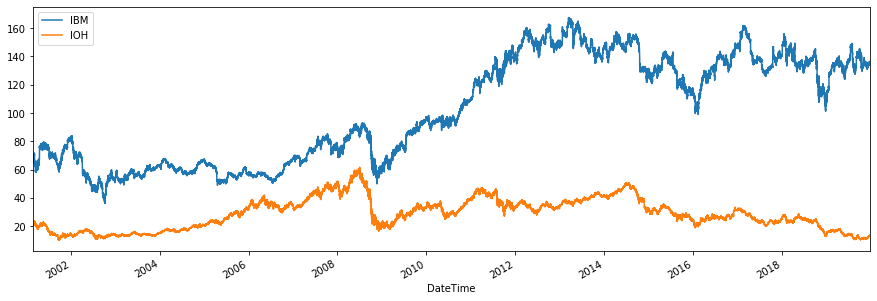

In [95]:
ds = pd.concat([s1, s2], axis=1)
ds = ds.dropna(how='any')
ds.columns = ['IBM', 'IOH']
ds.plot(figsize=(15,5))

In [96]:
ds

,IBM,IOH
DateTime,,
2001-02-26 09:41:00,69.7900,20.4800
2001-02-26 09:44:00,69.6350,20.5600
2001-02-26 09:46:00,69.2400,20.6400
2001-02-26 10:14:00,68.4900,20.8400
2001-02-26 10:18:00,68.3100,20.9600
...,...,...
2019-12-27 15:56:00,135.2675,13.3075
2019-12-27 15:57:00,135.2500,13.3000
2019-12-27 15:58:00,135.2500,13.3050


In [97]:
ds = ds[-100000:].copy()
ds['increaseIBM'] = (1+ds.IBM.pct_change()).fillna(1)
ds['increaseIOH'] = (1+ds.IOH.pct_change()).fillna(1)
ds['increaseGOD'] = ds.apply(lambda x: max(x.increaseIBM, x.increaseIOH), axis=1)
ds['positionGOD'] = ds.apply(lambda x: 'IBM' if x.increaseIBM>x.increaseIOH else 'IOH', axis=1)
ds['increaseDUM'] = ds.apply(lambda x: min(x.increaseIBM, x.increaseIOH), axis=1)
ds['positionDUM'] = ds.apply(lambda x: 'IBM' if x.increaseIBM<x.increaseIOH else 'IOH', axis=1)
ds['positionMON'] = [random.choice(['IBM','IOH']) for _ in range(len(ds))]
ds['increaseMON'] = ds.apply(lambda x: x['increase'+x.positionMON], axis=1)
# sanity check:
#ds.increaseIBM.prod()

In [98]:
100*(5000/100000)

5.0

In [99]:
moves = [None for _ in range(len(ds))]
indexes = [i for i in range(len(ds))]
goodMoves = np.random.choice(indexes, size = 4000, replace=False, p=None)
badMoves = np.random.choice(indexes, size = 1000, replace=False, p=None)
for gi in goodMoves: moves[gi]='positionGOD'
for bi in badMoves: moves[bi]='positionDUM'

ds['positionSTR'] = moves
ds['positionSTR'] = ds.apply(lambda x: x[x.positionSTR] if x.positionSTR is not None else None, axis=1)
   
positions = ds.positionSTR.values
positions[0]='IBM'

for i in range(1, len(positions)):
    positions[i]=positions[i-1] if positions[i]==None else positions[i]

ds['positionSTR']=positions
ds['increaseSTR']= ds.apply(lambda x: x['increase'+x.positionSTR], axis=1)

In [100]:
print(ds.increaseIBM.product())
print(ds.increaseIOH.product())
print(ds.increaseGOD.product())
print(ds.increaseMON.product())
print(ds.increaseDUM.product())

1.214163899111304
0.9116271093428071
855058410527.6173
1.4890707110272714
1.294490191532536e-12


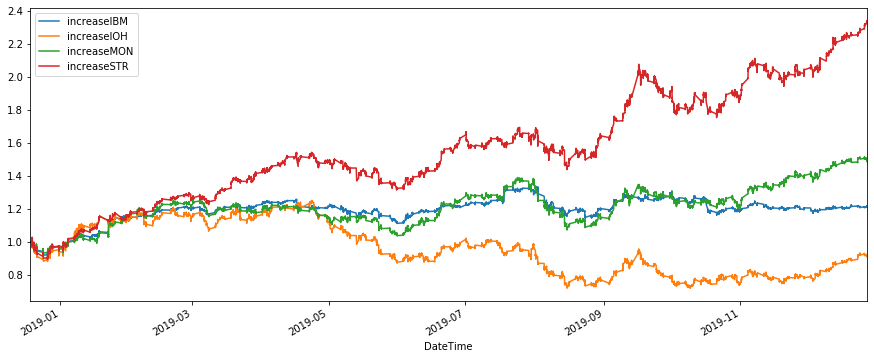

In [107]:
ds[[col for col in ds.columns if 'increase' in col ]].drop(columns=['increaseGOD', 'increaseDUM']).cumprod().plot(figsize=(15, 6))

In [116]:
positions = ds.positionSTR.values
counter = 0
for i in range(1, len(positions)):
    counter+=0 if positions[i]==positions[i-1] else 1
print(counter)

2504


In [111]:
2500

2500

In [112]:
ds.shape

(100000, 12)

In [113]:
import datetime as datetime

In [114]:
pd.Series(ds.index).apply(lambda x: datetime.date(x.year, x.month, x.day)).value_counts().index

Index([2019-08-05, 2019-11-04, 2019-08-14, 2018-12-20, 2018-12-19, 2019-01-23,
       2019-07-30, 2019-11-14, 2019-08-29, 2019-11-06,
       ...
       2019-07-12, 2019-08-16, 2019-02-22, 2019-05-03, 2019-02-26, 2018-12-24,
       2019-12-24, 2019-11-29, 2019-07-03, 2018-12-18],
      dtype='object', length=259)

In [105]:
#259 days 4800 transactions

In [118]:
2500/259

9.652509652509652

In [40]:
### this should be implemented as clear as possible!

transactionCost = 0.01
GOD = []
numStocksGOD = []
feesGOD=[]
IBM = list(ds.IBM)
IOH = list(ds.IOH)
positionGOD = list(ds.positionGOD)
increaseGOD = list(ds.increaseGOD)

GOD.append(100) #GOD starts with 100, as usual
numStocksGOD.append(GOD[-1]/(IBM[0] if positionGOD[0]=='IBM' else IOH[0]))
feesGOD.append(numStocksGOD[-1]* transactionCost)


for i in range(1, len(IBM)):
    feesGOD.append(numStocksGOD[-1]* transactionCost if positionGOD[i]!=positionGOD[i-1] else 0)
    GOD.append(GOD[-1]*increaseGOD[i]-feesGOD[-1])
    numStocksGOD.append(GOD[-1]/(IBM[0] if positionGOD[i]=='IBM' else IOH[i]))
    
    
ds['GOD'] = GOD
ds['numStocksGOD'] = numStocksGOD
ds['feesGOD']=feesGOD

In [41]:
ds.head()

,IBM,IOH,increaseIBM,increaseIOH,increaseGOD,positionGOD,increaseDUM,positionDUM,positionMON,increaseMON,positionSTR,increaseSTR,GOD,numStocksGOD,feesGOD
DateTime,,,,,,,,,,,,,,,
2018-12-18 15:59:00,111.41,14.578,1.000000,1.000000,1.000000,IOH,1.000000,IOH,IBM,1.000000,IBM,1.000000,100.000000,6.859652,0.068597
2018-12-18 16:01:00,111.31,14.585,0.999102,1.000480,1.000480,IOH,0.999102,IBM,IOH,1.000480,IBM,0.999102,100.048018,6.859652,0.000000
2018-12-19 09:03:00,111.51,14.652,1.001797,1.004594,1.004594,IOH,1.001797,IBM,IBM,1.001797,IBM,1.001797,100.507614,6.859652,0.000000
2018-12-19 09:08:00,111.53,14.633,1.000179,0.998703,1.000179,IBM,0.998703,IOH,IOH,0.998703,IBM,1.000179,100.457044,0.901688,0.068597
2018-12-19 09:29:00,111.64,14.652,1.000986,1.001298,1.001298,IOH,1.000986,IBM,IOH,1.001298,IBM,1.000986,100.578464,6.864487,0.009017


In [42]:
print(len(GOD))
print(len(numStocksGOD))
print(len(feesGOD))

100000
100000
100000


In [43]:
ds

,IBM,IOH,increaseIBM,increaseIOH,increaseGOD,positionGOD,increaseDUM,positionDUM,positionMON,increaseMON,positionSTR,increaseSTR,GOD,numStocksGOD,feesGOD
DateTime,,,,,,,,,,,,,,,
2018-12-18 15:59:00,111.4100,14.5780,1.000000,1.000000,1.000000,IOH,1.000000,IOH,IBM,1.000000,IBM,1.000000,1.000000e+02,6.859652,0.068597
2018-12-18 16:01:00,111.3100,14.5850,0.999102,1.000480,1.000480,IOH,0.999102,IBM,IOH,1.000480,IBM,0.999102,1.000480e+02,6.859652,0.000000
2018-12-19 09:03:00,111.5100,14.6520,1.001797,1.004594,1.004594,IOH,1.001797,IBM,IBM,1.001797,IBM,1.001797,1.005076e+02,6.859652,0.000000
2018-12-19 09:08:00,111.5300,14.6330,1.000179,0.998703,1.000179,IBM,0.998703,IOH,IOH,0.998703,IBM,1.000179,1.004570e+02,0.901688,0.068597
2018-12-19 09:29:00,111.6400,14.6520,1.000986,1.001298,1.001298,IOH,1.000986,IBM,IOH,1.001298,IBM,1.000986,1.005785e+02,6.864487,0.009017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27 15:56:00,135.2675,13.3075,1.000129,0.999437,1.000129,IBM,0.999437,IOH,IBM,1.000129,IBM,1.000129,1.009182e+06,9058.274759,758.400400
2019-12-27 15:57:00,135.2500,13.3000,0.999871,0.999436,0.999871,IBM,0.999436,IOH,IOH,0.999436,IBM,0.999871,1.009052e+06,9057.102861,0.000000
2019-12-27 15:58:00,135.2500,13.3050,1.000000,1.000376,1.000376,IOH,1.000000,IBM,IBM,1.000000,IBM,1.000000,1.009341e+06,75861.751332,90.571029


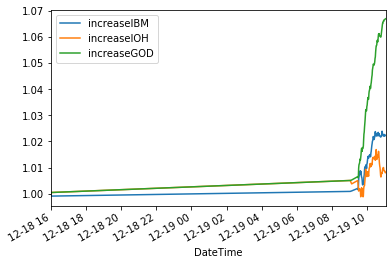

In [44]:
ds[['increaseIBM', 'increaseIOH', 'increaseGOD']][:100].cumprod().plot()

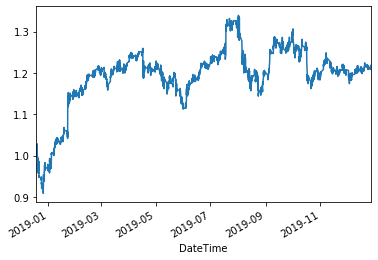

In [45]:
ds.increaseIBM.cumprod().plot()

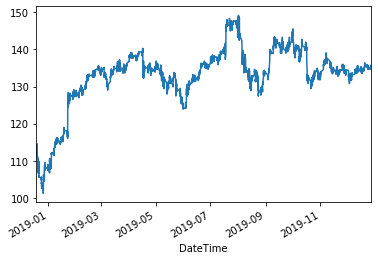

In [46]:
ds.IBM.plot()

In [47]:
ds.IBM.values[0]

111.41